In [1]:
import csv
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from collections import defaultdict
from datetime import datetime

import numpy
import scipy.optimize

In [2]:
def read_csv(path):
    rows = []
    with open(path, 'r') as file:
        csvreader = csv.reader(file)
        header = next(csvreader)
        for row in csvreader:
            rows.append(row)
    return header, rows

In [3]:
interaction_header, interactions = read_csv('archive/RAW_interactions.csv')

In [4]:
n_interactions = len(interactions)

interactionsTrain = interactions[:int(n_interactions * 0.95)]
interactionsValid = interactions[int(n_interactions * 0.95):]

interactionsPerUser = defaultdict(list)
interactionsPerRecipe = defaultdict(list)

for user, recipe, date, rating, review in interactionsTrain:
    rating = int(rating)
    interactionsPerUser[user].append((recipe,rating))
    interactionsPerRecipe[recipe].append((user,rating))

In [5]:
ratingAvg = 0
for user, recipe, date, rating, review in interactionsTrain:
    rating = int(rating)
    ratingAvg += rating
ratingAvg = ratingAvg / len(interactionsTrain)

N = len(interactionsTrain)
nUsers = len(interactionsPerUser)
nItems = len(interactionsPerRecipe)
users = list(interactionsPerUser.keys())
items = list(interactionsPerRecipe.keys())
labels = [int(r[3]) for r in interactionsTrain]


In [6]:
def MSE(predictions, labels):
    differences = [(x-y)**2 for x,y in zip(predictions,labels)]
    return sum(differences) / len(differences)

def prediction(user, item):
    if user not in userBiases.keys():
        user_bias = 0
    else:
        user_bias = userBiases[user]
    if item not in itemBiases.keys():
        item_bias = 0
    else:
        item_bias = itemBiases[item]

    return alpha + user_bias + item_bias

def unpack(theta):
    global alpha
    global userBiases
    global itemBiases
    alpha = theta[0]
    userBiases = dict(zip(users, theta[1:nUsers+1]))
    itemBiases = dict(zip(items, theta[1+nUsers:]))

def cost(theta, labels, lamb):
    unpack(theta)
    predictions = [prediction(d[0], d[1]) for d in interactionsTrain]
    cost = MSE(predictions, labels)
    print("MSE = " + str(cost))
    for u in userBiases:
        cost += lamb*userBiases[u]**2
    for i in itemBiases:
        cost += lamb*itemBiases[i]**2
    return cost

def derivative(theta, labels, lamb):
    unpack(theta)
    N = len(interactionsTrain)
    dalpha = 0
    dUserBiases = defaultdict(float)
    dItemBiases = defaultdict(float)
    for d in interactionsTrain:
        u,i = d[0], d[1]
        pred = prediction(u, i)
        diff = pred - int(d[3])
        dalpha += 2/N*diff
        dUserBiases[u] += 2/N*diff
        dItemBiases[i] += 2/N*diff
    for u in userBiases:
        dUserBiases[u] += 2*lamb*userBiases[u]
    for i in itemBiases:
        dItemBiases[i] += 2*lamb*itemBiases[i]
    dtheta = [dalpha] + [dUserBiases[u] for u in users] + [dItemBiases[i] for i in items]
    return numpy.array(dtheta)

In [7]:
##################################################
# Training                                       #
##################################################
alpha = ratingAvg
userBiases = defaultdict(float)
itemBiases = defaultdict(float)
lamb = 0.00003
scipy.optimize.fmin_l_bfgs_b(cost, [alpha] + [0.0]*(nUsers+nItems), derivative, args = (labels, lamb))

MSE = 1.6027857403287
MSE = 1.5885345972100628
MSE = 1.7557451281648446
MSE = 1.5826711479305628
MSE = 1.5731047068506734
MSE = 1.5726156123872181
MSE = 1.570702076819318
MSE = 1.563733411156382
MSE = 1.5346320506410809
MSE = 1.5185929741664346
MSE = 1.4863799429549327
MSE = 1.4679255195172403
MSE = 1.4521007265145245
MSE = 1.4409547044056101
MSE = 1.4280233600478383
MSE = 1.4044902200282903
MSE = 1.391001566385275
MSE = 1.3925948754424713
MSE = 1.3794777059522658
MSE = 1.371713825631914
MSE = 1.3731067781811452
MSE = 1.3583041850526107
MSE = 1.3677084208356296
MSE = 1.3692326181970516
MSE = 1.3681213936713796
MSE = 1.3656381303142018
MSE = 1.3635709117133148
MSE = 1.359606782337192
MSE = 1.355765998777765
MSE = 1.3498083894828166
MSE = 1.355535233769787
MSE = 1.3508781603193345
MSE = 1.378587661484973
MSE = 1.3505891996322144
MSE = 1.349809699458698
MSE = 1.3493840715920884
MSE = 1.34873466086062
MSE = 1.3477685971745599
MSE = 1.3404802945387002
MSE = 1.3459058364731549
MSE = 1.345043

(array([ 4.15455521,  0.30085779,  0.30910924, ..., -0.12194059,
         0.04676348,  0.01964554]),
 1.4201800282440953,
 {'grad': array([ 1.91751962e-06, -1.22655426e-07, -9.53429765e-08, ...,
          6.23430768e-09,  2.89485082e-10, -3.89323768e-09]),
  'task': 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL',
  'funcalls': 160,
  'nit': 129,
  'warnflag': 0})

In [12]:
##################################################
# Validation Run                                 #
##################################################
correct = 0
for user, recipe, date, rating, review in interactionsValid:
    label = int(rating)

    # Cold Start
    if user not in interactionsPerUser or recipe not in interactionsPerRecipe:
        pred = 5
    else:
        raw_pred = prediction(user, recipe)
        if raw_pred - int(raw_pred) > 0.5:
            pred = int(raw_pred) + 1
        else:
            pred = int(raw_pred)

    # raw_pred = prediction(user, recipe)
    # if raw_pred - int(raw_pred) > 0.5:
    #     pred = int(raw_pred) + 1
    # else:
    #     pred = int(raw_pred)

    pred = min(max(pred, 0), 5)

    if pred == label:
        correct += 1

accuracy = correct / len(interactionsValid)
accuracy

0.7188046415514227

In [4]:
recipe_header, recipes = read_csv('archive/RAW_recipes.csv')

['name', 'id', 'minutes', 'contributor_id', 'submitted', 'tags', 'nutrition', 'n_steps', 'steps', 'description', 'ingredients', 'n_ingredients']
['arriba   baked winter squash mexican style', '137739', '55', '47892', '2005-09-16', "['60-minutes-or-less', 'time-to-make', 'course', 'main-ingredient', 'cuisine', 'preparation', 'occasion', 'north-american', 'side-dishes', 'vegetables', 'mexican', 'easy', 'fall', 'holiday-event', 'vegetarian', 'winter', 'dietary', 'christmas', 'seasonal', 'squash']", '[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]', '11', "['make a choice and proceed with recipe', 'depending on size of squash , cut into half or fourths', 'remove seeds', 'for spicy squash , drizzle olive oil or melted butter over each cut squash piece', 'season with mexican seasoning mix ii', 'for sweet squash , drizzle melted honey , butter , grated piloncillo over each cut squash piece', 'season with sweet mexican spice mix', 'bake at 350 degrees , again depending on size , for 40 minutes up to an 

In [5]:
rating_count = defaultdict(int)
user_recipe_rating_map = {}
recipes_per_user = defaultdict(set)
users_per_recipe = defaultdict(set)


for user, recipe, date, rating, review in interactions:
    rating_count[rating] += 1
    user_recipe_rating_map[(user, recipe)] = int(rating)
    recipes_per_user[user].add(recipe)
    users_per_recipe[recipe].add(user)

user_avg_rating = {}
recipe_avg_rating = {}

for user in recipes_per_user.keys():
    ratings = []
    for recipe in recipes_per_user[user]:
        ratings.append(user_recipe_rating_map[(user, recipe)])
    avg_rating = sum(ratings) / len(ratings)
    user_avg_rating[user] = avg_rating

for recipe in users_per_recipe.keys():
    ratings = []
    for user in users_per_recipe[recipe]:
        ratings.append(user_recipe_rating_map[(user, recipe)])
    avg_rating = sum(ratings) / len(ratings)
    recipe_avg_rating[recipe] = avg_rating

In [6]:
# How many users/recipes/interactions entries?
users_ids = recipes_per_user.keys()
recipe_ids = users_per_recipe.keys()

print("users: ", len(users_ids))
print("recipes: ", len(recipe_ids))
print("interactions: ", len(interactions))

users:  226570
recipes:  231637
interactions:  1132367


In [7]:
# What is the overall distribution of ratings?
rating_count

defaultdict(int,
            {'4': 187360,
             '5': 816364,
             '0': 60847,
             '2': 14123,
             '3': 40855,
             '1': 12818})

In [8]:
# What is the global average rating?
sum_total = 0
count_total = 0
for rating, count in rating_count.items():
    sum_total += int(rating) * count
    count_total += count
global_avg_rating = sum_total / count_total; global_avg_rating

4.411016039852804

([0, 0, 0, 0, 0], [259205, 259260, 288000, 1051200, 2147483647])


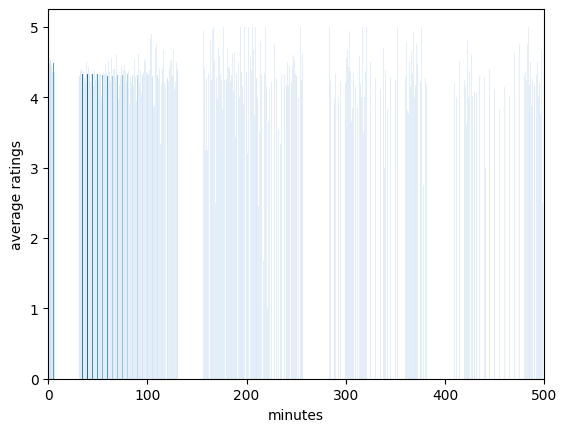

0.9812724219360465

In [9]:
# What is the overall distribution of minutes and their average ratings in the recipes?
minutes = [int(r[2]) for r in recipes]
minutes.sort()
print((minutes[:5], minutes[-5:]))

mins_to_recipe_ratings = defaultdict(list) 
for r in recipes:
    recipe, minute = r[1], r[2]
    mins_to_recipe_ratings[minute].append(recipe_avg_rating[recipe])

mins_to_avg_ratings = []
for minute, ratings in mins_to_recipe_ratings.items():
    avg = sum(ratings) / len(ratings)
    mins_to_avg_ratings.append((int(minute), avg, len(ratings)))

mins_to_avg_ratings.sort();

# Normalize bar color based on sample size
n_values = [n for _, _, n in mins_to_avg_ratings]
norm = mcolors.Normalize(vmin=min(n_values), vmax=max(n_values))

# Draw the diagram
def get_color(n):
    # Adjust the range of colors used. For example, 0.3 to 1.0.
    # This means the lightest color will not be too light.
    adjusted_n = 0.1 + 0.9 * norm(n)
    return plt.cm.Blues(adjusted_n)

for x, y, n in mins_to_avg_ratings:
    plt.bar(x, y, color=get_color(n))
plt.xlim(0, 500) 
plt.xlabel('minutes')
plt.ylabel('average ratings')
plt.show()

# minute < 500 (accounted for 98.13% of total samples)
count = 0
for r in recipes:
    minute = r[2]
    if int(minute) <= 500:
        count += 1
count / len(recipes)

([0, 1, 1, 1, 1, 1, 1, 1, 1, 1], [88, 90, 93, 97, 98, 100, 108, 110, 113, 145])


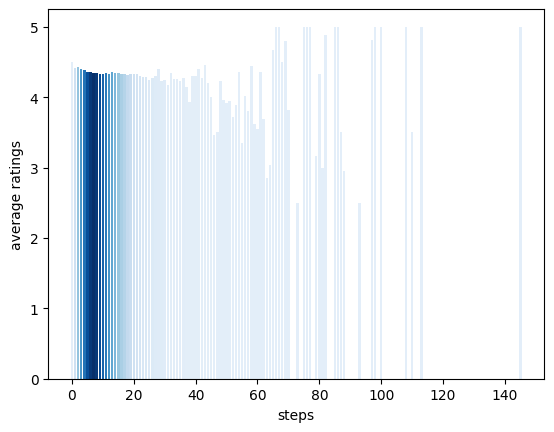

In [10]:
# What is the overall distribution of steps and their average ratings in the recipe?
steps = [int(r[7]) for r in recipes]
steps.sort()
print((steps[:10], steps[-10:]))

steps_to_recipe_ratings = defaultdict(list) 
for r in recipes:
    recipe, step = r[1], r[7]
    steps_to_recipe_ratings[step].append(recipe_avg_rating[recipe])

steps_to_avg_ratings = []
for step, ratings in steps_to_recipe_ratings.items():
    avg = sum(ratings) / len(ratings)
    steps_to_avg_ratings.append((int(step), avg, len(ratings)))

steps_to_avg_ratings.sort();

# Normalize bar color based on sample size
n_values = [n for _, _, n in steps_to_avg_ratings]
norm = mcolors.Normalize(vmin=min(n_values), vmax=max(n_values))

# Draw the diagram
def get_color(n):
    # Adjust the range of colors used. For example, 0.3 to 1.0.
    # This means the lightest color will not be too light.
    adjusted_n = 0.1 + 0.9 * norm(n)
    return plt.cm.Blues(adjusted_n)

for x, y, n in steps_to_avg_ratings:
    plt.bar(x, y, color=get_color(n))
# plt.xlim(0, 10) 
plt.xlabel('steps')
plt.ylabel('average ratings')
plt.show()

([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [35, 35, 36, 37, 37, 38, 39, 40, 40, 43])


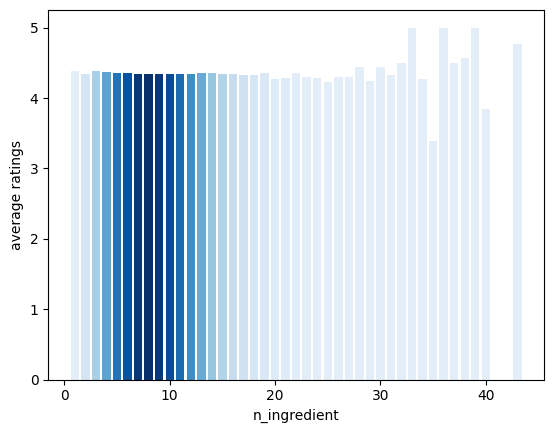

In [13]:
# What is the overall distribution of the number of ingredients and their average ratings in the recipe?
n_ingredient_list = [int(r[11]) for r in recipes]
n_ingredient_list.sort()
print((n_ingredient_list[:10], n_ingredient_list[-10:]))

n_ingredient_to_recipe_ratings = defaultdict(list) 
for r in recipes:
    recipe, n_ingredient = r[1], r[11]
    n_ingredient_to_recipe_ratings[n_ingredient].append(recipe_avg_rating[recipe])

n_ingredient_to_avg_ratings = []
for n_ingredient, ratings in n_ingredient_to_recipe_ratings.items():
    avg = sum(ratings) / len(ratings)
    n_ingredient_to_avg_ratings.append((int(n_ingredient), avg, len(ratings)))

n_ingredient_to_avg_ratings.sort();

# Normalize bar color based on sample size
n_values = [n for _, _, n in n_ingredient_to_avg_ratings]
norm = mcolors.Normalize(vmin=min(n_values), vmax=max(n_values))

# Draw the diagram
def get_color(n):
    # Adjust the range of colors used. For example, 0.3 to 1.0.
    # This means the lightest color will not be too light.
    adjusted_n = 0.1 + 0.9 * norm(n)
    return plt.cm.Blues(adjusted_n)

for x, y, n in n_ingredient_to_avg_ratings:
    plt.bar(x, y, color=get_color(n))
# plt.xlim(0, 10) 
plt.xlabel('n_ingredient')
plt.ylabel('average ratings')
plt.show()

In [14]:
# What are the top 10 most popular tags?
tag_count = defaultdict(int)
for r in recipes:
    recipe, tags = r[1], r[5]
    for tag in eval(tags):
        tag_count[tag] += 1

tag_list = []
for tag, count in tag_count.items():
    tag_list.append((count, tag))

tag_list.sort(reverse=True)
[t[1] for t in tag_list[:10]]

['preparation',
 'time-to-make',
 'course',
 'main-ingredient',
 'dietary',
 'easy',
 'occasion',
 'cuisine',
 'low-in-something',
 'main-dish']

In [15]:
# What time period does the dataset cover?
interaction_interval = None
for i in interactions:
    date = datetime.strptime(i[2], "%Y-%m-%d")
    if not interaction_interval:
        interaction_interval = [date, date]
    else:
        if date < interaction_interval[0]:
            interaction_interval[0] = date
        if date > interaction_interval[1]:
            interaction_interval[1] = date
print([i.strftime("%Y-%m-%d") for i in interaction_interval])

recipe_interval = None
for r in recipes:
    date = datetime.strptime(r[4], "%Y-%m-%d")
    if not recipe_interval:
        recipe_interval = [date, date]
    else:
        if date < recipe_interval[0]:
            recipe_interval[0] = date
        if date > recipe_interval[1]:
            recipe_interval[1] = date
print([i.strftime("%Y-%m-%d") for i in recipe_interval])

['2000-01-25', '2018-12-20']
['1999-08-06', '2018-12-04']


In [16]:
# Which are the recipes that are rated the best/worst (top 10) on average and their average ratings?
recipe_avg_rating_list = []

for recipe, rating in recipe_avg_rating.items():
    recipe_avg_rating_list.append((rating, recipe))

recipe_avg_rating_list.sort()

# Best recipes
print(recipe_avg_rating_list[-10:])
# Worse recipes
print(recipe_avg_rating_list[:10])

[(5.0, '99968'), (5.0, '99970'), (5.0, '99975'), (5.0, '99980'), (5.0, '99983'), (5.0, '99984'), (5.0, '99989'), (5.0, '99993'), (5.0, '99998'), (5.0, '99999')]
[(0.0, '100036'), (0.0, '100117'), (0.0, '100273'), (0.0, '100328'), (0.0, '10037'), (0.0, '100415'), (0.0, '100426'), (0.0, '100459'), (0.0, '10047'), (0.0, '100492')]
